In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
!pip install tensorlayer

    100% |████████████████████████████████| 317kB 23.6MB/s 
    100% |████████████████████████████████| 25.3MB 1.6MB/s 
    100% |████████████████████████████████| 61kB 19.7MB/s 
    100% |████████████████████████████████| 12.9MB 2.8MB/s 
    100% |████████████████████████████████| 2.0MB 6.8MB/s 
    100% |████████████████████████████████| 952kB 18.1MB/s 
yellowbrick 0.9 has requirement matplotlib<3.0,>=1.5.1, but you'll have matplotlib 3.0.2 which is incompatible.
spacy 2.0.18 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
google-colab 0.0.1a1 has requirement requests~=2.18.0, but you'll have requests 2.20.1 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: matplotlib 2.1.2
    Uninstalling matplotlib-2.1.2:
      Successfully uninstalled matplotlib-2.1.2
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successful

In [0]:
import os
import sys
import numpy as np
import datetime
import dateutil.tz
import argparse
from shutil import copyfile
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.layers import utils
import tensorflow.contrib.eager as tfe
from tensorflow.python.client import timeline
import tensorlayer as tl
import cv2
import scipy.misc
import PIL
import matplotlib.patches as patches
from PIL import Image

In [0]:
image = np.load('drive/image.npy')
label = np.load('drive/labels.npy')
box = np.load('drive/bbox.npy')

In [0]:
Data = image
label = label
bbox = box
epochs_completed = 0
index_in_epoch = 0
num_examples = len(image)

def next_batch(batch_size):

  global Data
  global label
  global bbox
  global index_in_epoch
  global epochs_completed

  start = index_in_epoch
  index_in_epoch += batch_size

	# when all trainig data have been already used, it is reorder randomly
  if index_in_epoch > num_examples:
		# finished epoch
    epochs_completed += 1
		# shuffle the data
    perm = np.arange(num_examples)
    np.random.shuffle(perm)
    Data = [Data[i] for i in perm]
    label = [label[i] for i in perm]
    bbox = [bbox[i] for i in perm]
		# start next epoch
    start = 0
    index_in_epoch = batch_size
    assert batch_size <= num_examples
  end = index_in_epoch
  return Data[start:end], label[start:end], bbox[start:end]

In [0]:
BATCH_SIZE = 16        # training batch size
batch_size = 16
MAX_ITER = 15000           # maximum number of iterations
IMG_WIDTH, IMG_HEIGHT = 64, 64      # image dimensions
IMG_CHANNELS = 3                    # image channels
LR_D = 3e-4                    # learning rate discriminator
LR_G = 1e-4                  # learning rate generator
BETA1_D = 0.5             # beta1 value for Adam optimizer (discriminator)
BETA1_G = 0.5              # beta1 value for Adam optimizer (generator)
n_batches = int(num_examples/batch_size)
Z_DIM = 128                # dimensionality of the z vector (input to G, incompressible noise)
LABEL_DIM = 200                      # dimensionality of the label vector (axis 1)
weight_init = tf.truncated_normal_initializer(stddev=0.02)
LOGDIR = 'drive/logs'


In [0]:
def sample_z(m, n):
    return np.random.normal(loc=0.0, scale=1.0, size=(m, n)).astype(np.float32)

In [0]:
def conv_cond_concat(x, y):
    """Concatenate conditioning vector on feature map axis."""
    x_shapes = tf.shape(x)
    y_shapes = y.get_shape()
    y = tf.reshape(y, (x_shapes[0], 1, 1, y_shapes[1]))
    z = tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[1]])
    y = tf.cast(y,'float32')
    y = y*z

    return tf.concat([x , y], 3)


In [0]:
def spatial_transformer_network(input_fmap, theta, out_dims=None, **kwargs):
    """
    Spatial Transformer Network layer implementation as described in [1].
    The layer is composed of 3 elements:
    - localisation_net: takes the original image as input and outputs 
      the parameters of the affine transformation that should be applied
      to the input image.
    - affine_grid_generator: generates a grid of (x,y) coordinates that 
      correspond to a set of points where the input should be sampled 
      to produce the transformed output.
    - bilinear_sampler: takes as input the original image and the grid
      and produces the output image using bilinear interpolation.
    Input
    -----
    - input_fmap: output of the previous layer. Can be input if spatial
      transformer layer is at the beginning of architecture. Should be 
      a tensor of shape (B, H, W, C). 
    - theta: affine transform tensor of shape (B, 6). Permits cropping, 
      translation and isotropic scaling. Initialize to identity matrix. 
      It is the output of the localization network.
    Returns
    -------
    - out_fmap: transformed input feature map. Tensor of size (B, H, W, C).
    Notes
    -----
    [1]: 'Spatial Transformer Networks', Jaderberg et. al,
         (https://arxiv.org/abs/1506.02025)
    """
    # grab input dimensions
    B = tf.shape(input_fmap)[0]
    H = tf.shape(input_fmap)[1]
    W = tf.shape(input_fmap)[2]
    C = tf.shape(input_fmap)[3]

    # reshape theta to (B, 2, 3)
    theta = tf.reshape(theta, [B, 2, 3])

    # generate grids of same size or upsample/downsample if specified
    if out_dims:
        out_H = out_dims[0]
        out_W = out_dims[1]
        batch_grids = affine_grid_generator(out_H, out_W, theta)
    else:
        batch_grids = affine_grid_generator(H, W, theta)

    x_s = batch_grids[:, 0, :, :]
    y_s = batch_grids[:, 1, :, :]

    # sample input with grid to get output
    out_fmap = bilinear_sampler(input_fmap, x_s, y_s)

    return out_fmap

def tf_compute_transformation_matrix(bbox, shape=16., img_height=64):
    rel_factor = float(shape)/img_height
    x, y, w, h = rel_factor*bbox[0], rel_factor*bbox[1], rel_factor*bbox[2], rel_factor*bbox[3]

    t_x = (x+0.5*w-0.5*shape)/(0.5*shape)
    t_y = (y+0.5*h-0.5*shape)/(0.5*shape)

    scale_x = (w / shape)
    scale_y = (h / shape)

    line0 = tf.stack((scale_x, 0.0, t_x))
    line1 = tf.stack((0.0, scale_y, t_y))
    transformation_matrix = tf.concat((line0, line1), axis=0)
    transformation_matrix = tf.reshape(transformation_matrix, (2, 3))

    return transformation_matrix 
  
  
def tf_compute_transformation_matrix_inverse(bbox, shape=16., img_height=64):
    rel_factor = float(shape)/img_height
    x, y, w, h = rel_factor*bbox[0], rel_factor*bbox[1], rel_factor*bbox[2], rel_factor*bbox[3]

    scale_x = (shape / w)
    scale_y = (shape / h)

    t_x = (shape - 2 * x) / w - 1
    t_y = (shape - 2 * y) / h - 1

    line0 = tf.stack((scale_x, 0.0, t_x))
    line1 = tf.stack((0.0, scale_y, t_y))

    transformation_matrix = tf.concat((line0, line1), axis=0)
    transformation_matrix = tf.reshape(transformation_matrix, (2, 3))

    return transformation_matrix  
  
def sample_gen_label(mb_size):
    labels = np.random.multinomial(1, 10*[0.1], size=mb_size)
    return labels.astype(np.float32)


def sample_gen_label_sorted(mb_size, label_dim=10):
    labels = np.zeros((mb_size, label_dim))
    for idx in range(label_dim):
        labels[idx*label_dim:idx*label_dim+label_dim, idx] = 1
    return labels.astype(np.float32)


def sample_bbox(mb_size):
    pos_box_x = np.random.randint(low=0, high=44, size=(mb_size, 1))
    pos_box_y = np.random.randint(low=0, high=44, size=(mb_size, 1))

    coin = np.random.binomial(1, 0.5)
    if coin < 0.1:
        scale_box_x = np.random.randint(low=8, high=16, size=(mb_size, 1))
    elif 0.1 < coin < 0.8:
        scale_box_x = np.random.randint(low=12, high=18, size=(mb_size, 1))
    else:
        scale_box_x = np.random.randint(low=16, high=21, size=(mb_size, 1))
    scale_box_y = np.random.randint(low=18, high=21, size=(mb_size, 1))

    boxes = np.concatenate((pos_box_x, pos_box_y, scale_box_x, scale_box_y), axis=1)
    return boxes.astype(np.float32)


def sample_bbox_sorted(mb_size, sort_size=False):
    pos_box_x = np.zeros((mb_size, 1))
    for idx in range(100):
        pos_box_x[idx, 0] = (idx % 10 + 1) * 4

    pos_box_y = np.zeros((mb_size, 1))
    for idx in range(10):
        pos_box_y[idx * 10:idx * 10 + 10, 0] = (idx + 1) * 4

    if sort_size:
        scale_box_x = np.zeros((mb_size, 1))
        for idx in range(100):
            scale_box_x[idx, 0] = (idx % 10 + 1) + 10

        scale_box_y = np.zeros((mb_size, 1))
        for idx in range(10):
            scale_box_y[idx * 10:idx * 10 + 10, 0] = (idx + 1) + 10
    else:
        scale_box_x = np.random.randint(low=16, high=21, size=(mb_size, 1))
        scale_box_y = np.random.randint(low=18, high=21, size=(mb_size, 1))

    boxes = np.concatenate((pos_box_x, pos_box_y, scale_box_x, scale_box_y), axis=1)
    return boxes.astype(np.float32)


def sample_generator_input(mb_size, n, sort_labels=False, sort_location=False, sort_bbox_size=False):
    _z = sample_z(mb_size, n)
    _Y = sample_gen_label_sorted(mb_size) if sort_labels else sample_gen_label(mb_size)

    if sort_bbox_size:
        _bbox = sample_bbox_sorted(mb_size, sort_size=True)
    else:
        _bbox = sample_bbox_sorted(mb_size) if sort_location else sample_bbox(mb_size)


    return _z, _Y, _bbox

def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature 
    map, will create an output feature map that is an 
    affine transformation [1] of the input feature map.
    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample. 
    - width: desired width of grid/output. Used
      to downsample or upsample. 
    - theta: affine transform matrices of shape (num_batch, 2, 3). 
      For each image in the batch, we have 6 theta parameters of 
      the form (2x3) that define the affine transformation T.
    Returns
    -------
    - normalized gird (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the 
      sampling points of the original image for each point in the
      target image.
    Note
    ----
    [1]: the affine transformation allows cropping, translation, 
         and isotropic scaling.
    """
    # grab batch size
    num_batch = tf.shape(theta)[0]

    # create normalized 2D grid
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)

    # flatten
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))

    # cast to float32 (required for matmul)
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')

    # transform the sampling grid - batch multiply
    batch_grids = tf.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, H, W, 2)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids

def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the 
    normalized coordinates provided by the sampling grid. Note that 
    the sampling is done identically for each channel of the input.
    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.
    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.
    Returns
    -------
    - interpolated images according to grids. Same size as grid.
    """
    # prepare useful params
    B = tf.shape(img)[0]
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    C = tf.shape(img)[3]

    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')

    # cast indices as float32 (for rescaling)
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')

    # rescale x and y to [0, W/H]
    x = 0.5 * ((x + 1.0) * tf.cast(W, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(H, 'float32'))

    # grab 4 nearest corner points for each (x_i, y_i)
    # i.e. we need a rectangle around the point of interest
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # clip to range [0, H/W] to not violate img boundaries
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)

    # add dimension for addition
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)

    # compute output
    out = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id])


    return out  
  
def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.
    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W, )
    - y: flattened tensor of shape (B*H*W, )
    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]

    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
    b = tf.tile(batch_idx, (1, height, width))

    indices = tf.stack([b, y, x], 3)

    return tf.gather_nd(img, indices)  

In [0]:
def transform(img):
    img = np.divide(np.add(img,1),2.0)
    return img
  
def process_oneimg(img):
  img = np.subtract(np.multiply(img , 2),1.0)
  return img

def lrelu(x,alpha=0.2):
	return tf.maximum(x,alpha*x)	

def conv2d(x, features, kernel=[4,4], strides=[1,2,2,1], name="conv_layer"):
	with tf.variable_scope(name) as scope:
		weights = weight(shape=kernel + features, name="weights")
		biases = bias(shape=[features[-1]], name="bias")
		output = tf.nn.conv2d(x, weights, strides=strides, padding='SAME') 
		output = tf.nn.bias_add(output, biases)
		return output	

def deconv2d(x, features, output_shape, kernel=[4,4], strides=[1,2,2,1], name="deconv_layer"):
	with tf.variable_scope(name) as scope:
		weights = weight(shape=kernel + features, name="weights")
		biases = bias(shape=[features[0]], name="bias")
		output = tf.nn.conv2d_transpose(x, weights, output_shape=output_shape, strides=strides, padding='SAME') 
		return tf.reshape(tf.nn.bias_add(output, biases), output.get_shape())

def bias(shape, name):
	return tf.get_variable(name, shape,initializer=tf.constant_initializer(0.00000))

def weight(shape, name):
	return tf.get_variable(name, shape,initializer=tf.glorot_uniform_initializer())	

def dense(x, shape, name):
	with tf.variable_scope(name):
		weights = weight(shape, name="weights")
		biases = bias([shape[-1]], name="bias")
		return tf.matmul(x,weights) + biases

def batch_norm(inputs, decay=0.9, epsilon=0.00001, scale=True, isTrain=True, name="batch_norm"):
	return tf.contrib.layers.batch_norm(inputs, decay=decay, scale=scale, epsilon=epsilon, updates_collections=None, is_training=isTrain, scope=name)			


In [0]:
def discriminate(image_input, label, bounding_box,reuse):
  with tf.variable_scope("discriminator") as scope:
    if reuse:
      scope.reuse_variables()
    #input = conv_cond_concat(image_input, label)
    d_x_conv_0 = conv2d(image_input, features=[3, 32],kernel=[5,5], name="d_conv_layer_1")
    d_x_conv_0 = lrelu(d_x_conv_0)
      
    d_x_conv_1 = conv2d(d_x_conv_0, features=[32, 64], kernel=[5,5],name="d_conv_layer_2")
    d_x_conv_1 = batch_norm(d_x_conv_1, isTrain=True, name="d_batch_norm_2")
    d_x_conv_1 = lrelu(d_x_conv_1)
      
    ####################################################
    # global pathway
      
    d_x_conv_global_0 = conv2d(d_x_conv_1, features=[64, 64], kernel=[5,5],name="d_conv_global_1")
    d_x_conv_global_0 = batch_norm(d_x_conv_global_0, isTrain=True, name="d_batch_global_1")
    d_x_conv_global_0 = lrelu(d_x_conv_global_0)
      
    d_x_conv_global_1 = conv2d(d_x_conv_global_0, features=[64, 128], kernel=[5,5],name="d_conv_global_2")
    d_x_conv_global_1 = batch_norm(d_x_conv_global_1, isTrain=True, name="d_batch_global_2")
    d_x_conv_global_1 = lrelu(d_x_conv_global_1)
      
    shp = [int(s) for s in d_x_conv_global_1.shape[1:]]
    d_x_conv_global_1 = tf.reshape(d_x_conv_global_1, [-1, shp[0] * shp[1] * shp[2]])

    ####################################################
    # local pathway
    # reshape bounding box to (16, 16) resolution
    transf_matri = tf.map_fn(tf_compute_transformation_matrix, bounding_box)
    local_input = spatial_transformer_network(d_x_conv_1, transf_matri, (16, 16))
      
    d_x_conv_local_0 = conv2d(local_input, features=[64, 64], kernel=[5,5],name="d_conv_local_0")
    d_x_conv_local_0 = batch_norm(d_x_conv_local_0, isTrain=True, name="d_batch_local_0")
    d_x_conv_local_0 = lrelu(d_x_conv_local_0)
      
    d_x_conv_local_1 = conv2d(d_x_conv_local_0, features=[64, 128], kernel=[5,5],name="d_conv_local_1")
    d_x_conv_local_1 = batch_norm(d_x_conv_local_1, isTrain=True, name="d_batch_local_1")
    d_x_conv_local_1 = lrelu(d_x_conv_local_1)
      
    shp = [int(s) for s in d_x_conv_local_1.shape[1:]]
    d_x_conv_local_1 = tf.reshape(d_x_conv_local_1, [-1, shp[0] * shp[1] * shp[2]])

    ####################################################
    # final discriminator
    final_input = tf.concat((d_x_conv_global_1, d_x_conv_local_1), axis=1)
      
    d_final_dense = dense(final_input, shape=[4096, 512], name="d_final_dense_1")
    d_final_dense = batch_norm(d_final_dense, isTrain=True, name="d_batch_dense_1")
    d_final_dense = lrelu(d_final_dense)
      
    d_final_pred = dense(d_final_dense, shape=[512, 1],name="d_final_dense_2")

    return d_final_pred,tf.nn.sigmoid(d_final_pred)



In [0]:
def sampler(noise_input, label, bounding_box):
  with tf.variable_scope("g_net") as scope:
    scope.reuse_variables()
    
    #input = tf.concat((noise_input, label), axis=1)
    g_dense_0 = dense(noise_input, shape=[128, 2048], name="g_dense_1")
    g_dense_0 = batch_norm(g_dense_0, isTrain=False, name="g_batch_norm_0")
    g_dense_0 = tf.nn.relu(g_dense_0)

    g_dense_0 = tf.reshape(g_dense_0, [-1, 4, 4, 128])

    ####################################################
    # global pathway
        
    g_conv_global_0 = deconv2d(g_dense_0, features=[256, 128], output_shape=[batch_size,8,8,256], name="g_deconv_global_1")
    g_conv_global_0 = batch_norm(g_conv_global_0, isTrain=False, name="g_batch_global_1")
    g_conv_global_0 = tf.nn.relu(g_conv_global_0)

    g_conv_global_1 = deconv2d(g_conv_global_0, features=[256, 256], output_shape=[batch_size,16,16,256], name="g_deconv_global_2")
    g_conv_global_1 = batch_norm(g_conv_global_1, isTrain=False, name="g_batch_global_2")
    g_conv_global_1 = tf.nn.relu(g_conv_global_1)
        
        
    ####################################################
    # local pathway
        
    g_conv_local_0 = deconv2d(g_dense_0, features=[256, 128], output_shape=[batch_size,8,8,256], name="g_deconv_local_1")
    g_conv_local_0 = batch_norm(g_conv_local_0, isTrain=False, name="g_batch_local_1")
    g_conv_local_0 = tf.nn.relu(g_conv_local_0)

    g_conv_local_1 = deconv2d(g_conv_local_0, features=[256, 256], output_shape=[batch_size,16,16,256], name="g_deconv_local_2")
    g_conv_local_1 = batch_norm(g_conv_local_1, isTrain=False, name="g_batch_local_2")
    g_conv_local_1 = tf.nn.relu(g_conv_local_1)
        
    # reshape to bounding box
    transf_matri = tf.map_fn(tf_compute_transformation_matrix_inverse, bounding_box)
    g_conv_local_1 = spatial_transformer_network(g_conv_local_1, transf_matri, (16, 16))

    ####################################################
    # final pathway
    final_input = tf.concat((g_conv_global_1, g_conv_local_1), axis=3)
    g_conv_final = deconv2d(final_input, features=[256, 512], output_shape=[batch_size,32,32,256], name="g_deconv_final_1")
    g_conv_final = batch_norm(g_conv_final, isTrain=False, name="g_batch_final_1")
    g_conv_final = tf.nn.relu(g_conv_final)
        
    g_conv_final_2 = deconv2d(g_conv_final, features=[256, 256], output_shape=[batch_size,64,64,256], name="g_deconv_final_2")
    g_conv_final_2 = batch_norm(g_conv_final_2, isTrain=False, name="g_batch_final_2")
    g_conv_final_2 = tf.nn.relu(g_conv_final_2)
        
        
    g_conv_out = deconv2d(g_conv_final_2, features=[3, 256], output_shape=[batch_size,64,64,3],strides=[1,1,1,1], name="g_deconv_output_1")
    g_conv_out= tf.nn.tanh(g_conv_out)

    return g_conv_out

In [0]:
def generate(noise_input, label, bounding_box):
  with tf.variable_scope("g_net") as scope:
    #input = tf.concat((noise_input, label), axis=1)
    g_dense_0 = dense(noise_input, shape=[128, 2048], name="g_dense_1")
    g_dense_0 = batch_norm(g_dense_0, isTrain=False, name="g_batch_norm_0")
    g_dense_0 = tf.nn.relu(g_dense_0)

    g_dense_0 = tf.reshape(g_dense_0, [-1, 4, 4, 128])

    ####################################################
    # global pathway
        
    g_conv_global_0 = deconv2d(g_dense_0, features=[256, 128], output_shape=[batch_size,8,8,256], name="g_deconv_global_1")
    g_conv_global_0 = batch_norm(g_conv_global_0, isTrain=True, name="g_batch_global_1")
    g_conv_global_0 = tf.nn.relu(g_conv_global_0)

    g_conv_global_1 = deconv2d(g_conv_global_0, features=[256, 256], output_shape=[batch_size,16,16,256], name="g_deconv_global_2")
    g_conv_global_1 = batch_norm(g_conv_global_1, isTrain=True, name="g_batch_global_2")
    g_conv_global_1 = tf.nn.relu(g_conv_global_1)
        
        
    ####################################################
    # local pathway
        
    g_conv_local_0 = deconv2d(g_dense_0, features=[256, 128], output_shape=[batch_size,8,8,256], name="g_deconv_local_1")
    g_conv_local_0 = batch_norm(g_conv_local_0, isTrain=True, name="g_batch_local_1")
    g_conv_local_0 = tf.nn.relu(g_conv_local_0)

    g_conv_local_1 = deconv2d(g_conv_local_0, features=[256, 256], output_shape=[batch_size,16,16,256], name="g_deconv_local_2")
    g_conv_local_1 = batch_norm(g_conv_local_1, isTrain=True, name="g_batch_local_2")
    g_conv_local_1 = tf.nn.relu(g_conv_local_1)
        
    # reshape to bounding box
    transf_matri = tf.map_fn(tf_compute_transformation_matrix_inverse, bounding_box)
    g_conv_local_1 = spatial_transformer_network(g_conv_local_1, transf_matri, (16, 16))

    ####################################################
    # final pathway
    final_input = tf.concat((g_conv_global_1, g_conv_local_1), axis=3)
    g_conv_final = deconv2d(final_input, features=[256, 512], output_shape=[batch_size,32,32,256], name="g_deconv_final_1")
    g_conv_final = batch_norm(g_conv_final, isTrain=True, name="g_batch_final_1")
    g_conv_final = tf.nn.relu(g_conv_final)
        
    g_conv_final_2 = deconv2d(g_conv_final, features=[256, 256], output_shape=[batch_size,64,64,256], name="g_deconv_final_2")
    g_conv_final_2 = batch_norm(g_conv_final_2, isTrain=True, name="g_batch_final_2")
    g_conv_final_2 = tf.nn.relu(g_conv_final_2)
        
        
    g_conv_out = deconv2d(g_conv_final_2, features=[3, 256], output_shape=[batch_size,64,64,3],strides=[1,1,1,1], name="g_deconv_output_1")
    g_conv_out= tf.nn.tanh(g_conv_out)

    return g_conv_out

In [101]:
tf.reset_default_graph()

Y = tf.placeholder(tf.float32, shape=[None,LABEL_DIM], name='label')
X = tf.placeholder(tf.float32, shape=[None,64,64,3], name='image')
b = tf.placeholder(tf.float32, shape=[None,4], name='box')

z = tf.placeholder(tf.float32, shape=[None,Z_DIM], name='z')
Y_ = tf.placeholder(tf.float32, shape=[None,10], name='label_gen')
b_ = tf.placeholder(tf.float32, shape=[None,4], name='box_gen')

fake_images = generate(noise_input=z, label=Y, bounding_box=b)
fake_disc_logits, fake_disc = discriminate(image_input=fake_images, label=Y, bounding_box=b, reuse=False)
real_img_real_label_disc_logits, real_disc_real = discriminate(image_input=X, label=Y, bounding_box=b, reuse=True)
real_img_fake_label_disc_logits, real_disc_fake = discriminate(image_input=X, label=Y, bounding_box=b_, reuse=True)
sample = sampler(noise_input=z, label=Y, bounding_box=b)


d_loss1 = tl.cost.sigmoid_cross_entropy(real_img_real_label_disc_logits, tf.ones_like(real_img_real_label_disc_logits), name='d1')
d_loss2 = tl.cost.sigmoid_cross_entropy(real_img_fake_label_disc_logits,  tf.zeros_like(real_img_fake_label_disc_logits), name='d2')
d_loss3 = tl.cost.sigmoid_cross_entropy(fake_disc_logits, tf.zeros_like(fake_disc_logits), name='d3')
d_loss = d_loss1 + (d_loss2 + d_loss3)
g_loss = tl.cost.sigmoid_cross_entropy(fake_disc_logits, tf.ones_like(fake_disc_logits), name='g')

tf.summary.scalar("g_loss", g_loss)
tf.summary.scalar("d_loss", d_loss)

lr = 0.0002
lr_decay = 0.5      # decay factor for adam, https://github.com/reedscot/icml2016/blob/master/main_cls_int.lua  https://github.com/reedscot/icml2016/blob/master/scripts/train_flowers.sh
decay_every = 100   # https://github.com/reedscot/icml2016/blob/master/main_cls.lua
beta1 = 0.5
t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

d_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(lr, beta1=0.5).minimize(g_loss, var_list=g_vars)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  saver = tf.train.Saver(max_to_keep=2)
  summary_writer = tf.summary.FileWriter(LOGDIR, sess.graph)
  ckpt = tf.train.get_checkpoint_state(LOGDIR)
  epoch=0
  if ckpt and ckpt.model_checkpoint_path:
      saver.restore(sess, ckpt.model_checkpoint_path)
      print("Model restored...")
      epoch = int(ckpt.model_checkpoint_path.split('-')[1])
      print("starting from iteration", epoch)
  z_mb, Y_gen, box_generated = sample_generator_input(BATCH_SIZE, Z_DIM)
  #z_mb = z_new
  #_, Y_gen, box_generated = sample_generator_input(BATCH_SIZE, Z_DIM)
  data_1, label_1, bbox_1 = next_batch(BATCH_SIZE)
  data_1 = process_oneimg(data_1)
  feed_dict = {Y:label_1,X:data_1,b:bbox_1,z:z_mb,Y_:Y_gen,b_:box_generated}
  fake_image = sess.run(sample,feed_dict=feed_dict)    
  
  '''
  while epoch!=1000:
    dl, gl = [],[]
      
    if epoch % 50 == 0 :
        saver.save(sess, LOGDIR + "/model.ckpt", global_step=epoch)
  
    for i in range(n_batches):
      z_mb, Y_gen, box_generated = sample_generator_input(BATCH_SIZE, Z_DIM)
      data_1, label_1, bbox_1 = next_batch(BATCH_SIZE)
      data_1 = process_oneimg(data_1)
      feed_dict = {Y:label_1,X:data_1,b:bbox_1,z:z_mb,Y_:Y_gen,b_:box_generated}
      _, DLOSS = sess.run([d_optim, d_loss],feed_dict=feed_dict)
			
			# Update G network
      _, GLOSS = sess.run([g_optim, g_loss],feed_dict=feed_dict)

			# Update G network
      _, GLOSS = sess.run([g_optim, g_loss],feed_dict=feed_dict)
      _, GLOSS = sess.run([g_optim, g_loss],feed_dict=feed_dict)
      
      
      dl.append(DLOSS)
      gl.append(GLOSS)
    print('discriminator_loss / generator_loss => %.2f / %.2f for step %d'%(np.mean(dl), np.mean(gl), epoch))
    z_mb, Y_gen, box_generated = sample_generator_input(BATCH_SIZE, Z_DIM)
    data_1, label_1, bbox_1 = next_batch(BATCH_SIZE)
    data_1 = process_oneimg(data_1)
    feed_dict = {Y:label_1,X:data_1,b:bbox_1,z:z_mb,Y_:Y_gen,b_:box_generated}
    fake_image = sess.run(sample,feed_dict=feed_dict)
    plt.imsave('drive/new_result/'+str(epoch)+'.jpg',transform(fake_image[0]))
    epoch+=1

  '''

INFO:tensorflow:Restoring parameters from drive/logs/model.ckpt-150
Model restored...
starting from iteration 150


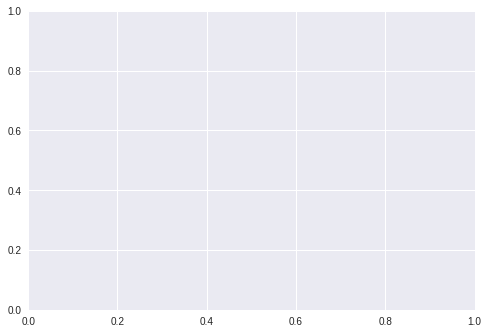

In [173]:
i = 12
x = bbox_1[i][0]
y = bbox_1[i][1]
width = bbox_1[i][2]
height = bbox_1[i][3]
im = transform(fake_image[i])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.rectangle(im,(x,y),(x+width,y+height),(0,255,0),1).astype('uint8')

print(np.max(im))
#cv2.imwrite('drive/'+str(101)+'.png',im)
#im1 = im/255
im = im + im1
#im = im.astype('uint8')
print(np.max(im))
plt.imshow(im)
plt.imsave('drive/'+str(100)+'.jpg',im)

In [0]:
list = z_mb[8]
z_new = [list for i in range(16)]

In [0]:
plt.imsave('drive/'+str(100)+'.jpg',im)

In [121]:
np.min(im)

0.0